# 1.Introduction
### This notebook outlines the process of building a machine learning model to predict California house prices using the California Housing dataset. Our primary goal is to train a model that can accurately estimate the median house value for a given district.

### We will begin by performing a thorough Exploratory Data Analysis (EDA) to understand the dataset's characteristics, including feature distributions and correlations. After preparing the data, we will first establish a baseline using a simple Linear Regression model. We will then improve upon this baseline by training and evaluating more sophisticated tree-based models, specifically LightGBM, CatBoost, and XGBoost.

### To further boost our model's predictive power, we will implement ensemble learning through stacking. This technique combines the predictions of our individual models to create a final, more robust prediction. Finally, to ensure the generalizability of our best model, we will employ k-fold cross-validation. This systematic approach allows us to compare model performance and select the most effective and reliable algorithm for this prediction task.



#### Downloading the dataset and saving it to a path

In [2]:
import os
import tarfile
import urllib
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
 os.makedirs(housing_path, exist_ok=True)
 tgz_path = os.path.join(housing_path, "housing.tgz")
 urllib.request.urlretrieve(housing_url, tgz_path)
 housing_tgz = tarfile.open(tgz_path)
 housing_tgz.extractall(path=housing_path,filter='tar')
 housing_tgz.close()

In [3]:
fetch_housing_data()

# 2. Setup and Data Loading
- First, we need to import the necessary libraries and load the dataset. We'll use pandas for data manipulation and scikit-learn to load the dataset.

In [7]:
HOUSING_PATH = os.path.join("data")

In [8]:
import pandas as pd
def load_housing_data(housing_path=HOUSING_PATH):
 csv_path = os.path.join(housing_path, "housing.csv")
 return pd.read_csv(csv_path)

In [ ]:
housing=load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## 3. Exploratory Data Analysis (EDA)
### Before we build a model, let's understand our data. We will check for missing values, examine the distribution of features, and look for correlations. 

In [40]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [41]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


### Visualize the distribution of the target variable, median_house_value, and the other features. A histogram can show us if the data is skewed.

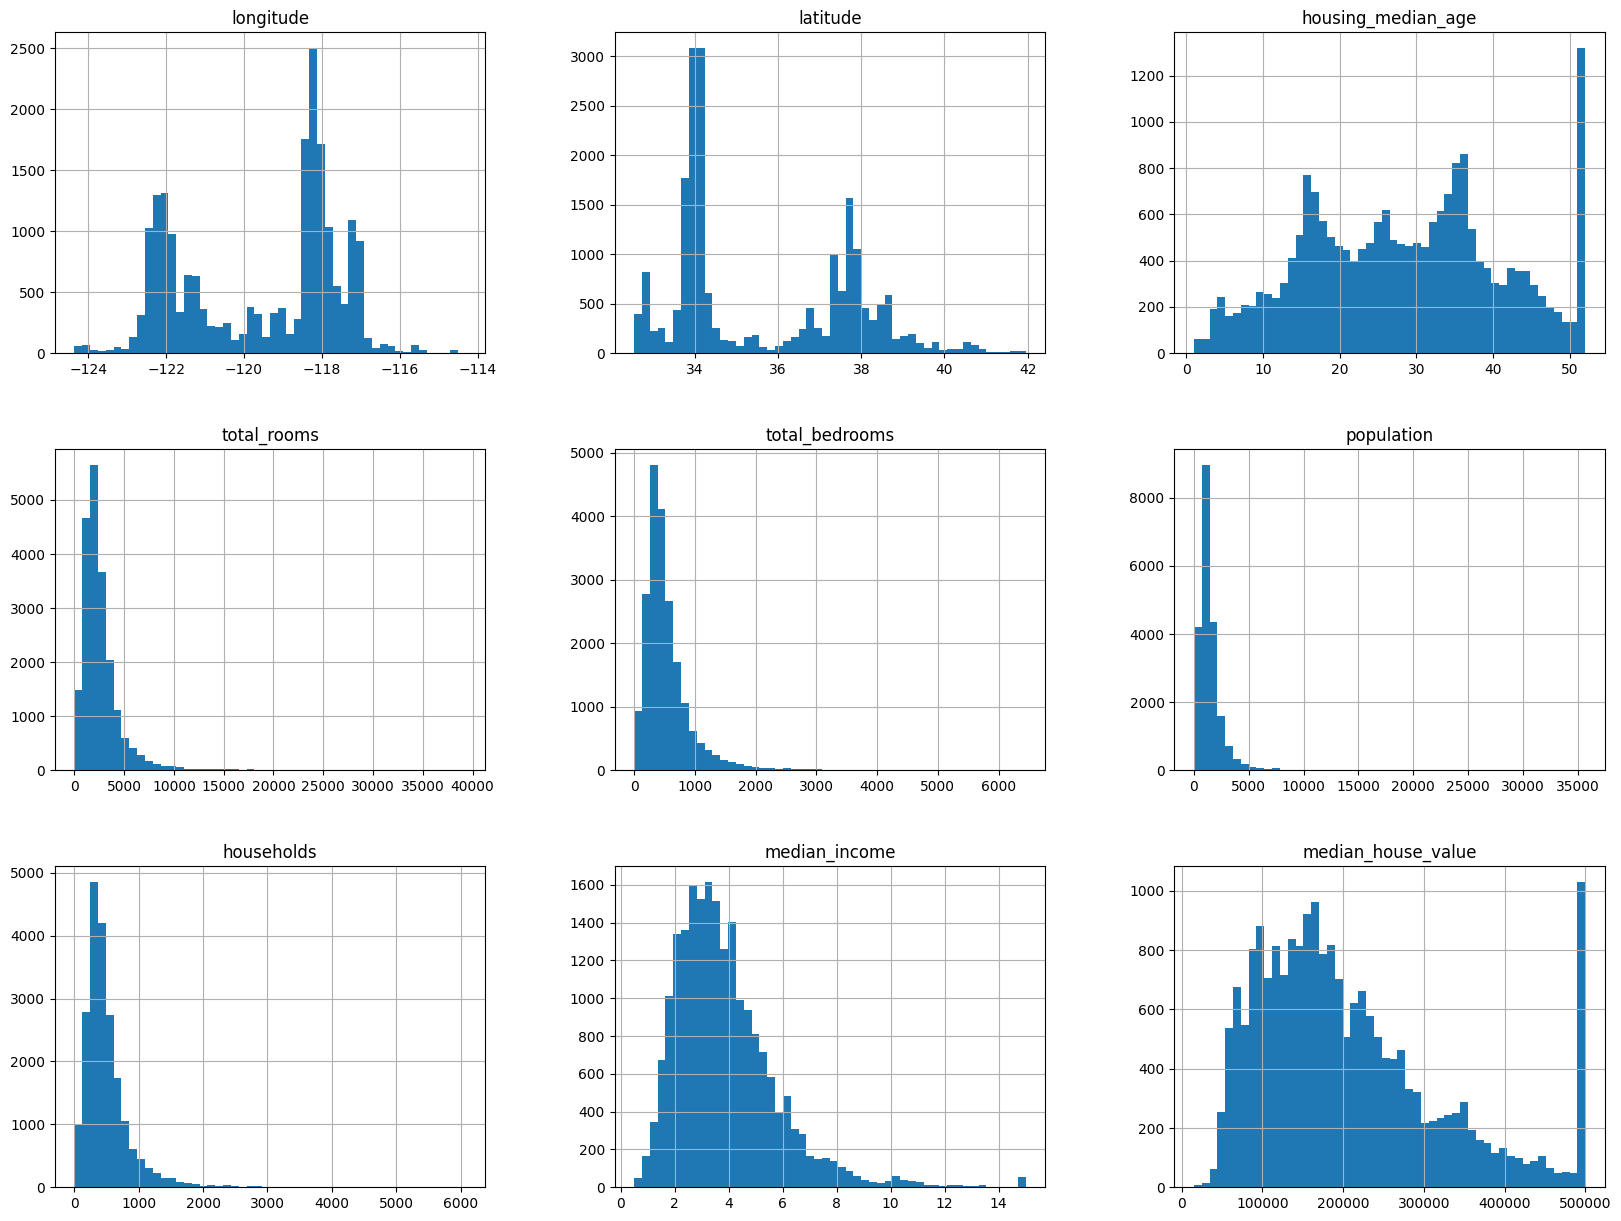

In [42]:
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

### Data Splitting

In [43]:
import numpy as np
def split_train_test(data, test_ratio):
 shuffled_indices = np.random.permutation(len(data))
 test_set_size = int(len(data) * test_ratio)
 test_indices = shuffled_indices[:test_set_size]
 train_indices = shuffled_indices[test_set_size:]
 return data.iloc[train_indices], data.iloc[test_indices]

In [44]:
train,test=split_train_test(housing,0.2)

In [45]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

### Now the data is shuffled properly and splitted

In [46]:
train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
14196,-117.03,32.71,33.0,3126.0,627.0,2300.0,623.0,3.2596,103000.0,NEAR OCEAN
8267,-118.16,33.77,49.0,3382.0,787.0,1314.0,756.0,3.8125,382100.0,NEAR OCEAN
17445,-120.48,34.66,4.0,1897.0,331.0,915.0,336.0,4.1563,172600.0,NEAR OCEAN
14265,-117.11,32.69,36.0,1421.0,367.0,1418.0,355.0,1.9425,93400.0,NEAR OCEAN
2271,-119.80,36.78,43.0,2382.0,431.0,874.0,380.0,3.5542,96500.0,INLAND


### Adding column: income category

In [47]:
housing["income_cat"]=pd.cut(housing["median_income"],
                                bins=[0,1.5,3,4.5,6,np.inf],
                                labels=[1,2,3,4,5])

<Axes: >

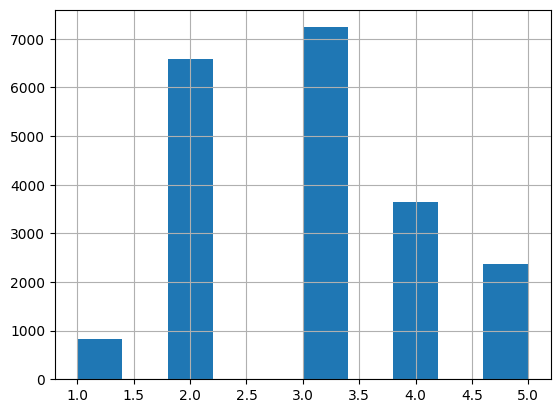

In [49]:
housing["income_cat"].hist()

In [48]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
 strat_train_set = housing.loc[train_index]
 strat_test_set = housing.loc[test_index]
strat_train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,72100.0,INLAND,2
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,279600.0,NEAR OCEAN,5
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,82700.0,INLAND,2
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,112500.0,NEAR OCEAN,2
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,238300.0,<1H OCEAN,3


In [50]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [51]:
strat_train_set.head()
housing=strat_train_set.copy()
strat_train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,72100.0,INLAND
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,279600.0,NEAR OCEAN
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,82700.0,INLAND
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,112500.0,NEAR OCEAN
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,238300.0,<1H OCEAN


## Visualizing Geographical Data
### This section visualizes the California Housing data on a map, which is crucial for understanding its geographical distribution. The scatter plot below shows the different districts based on their longitude and latitude. The plot is enhanced with several visual cues:

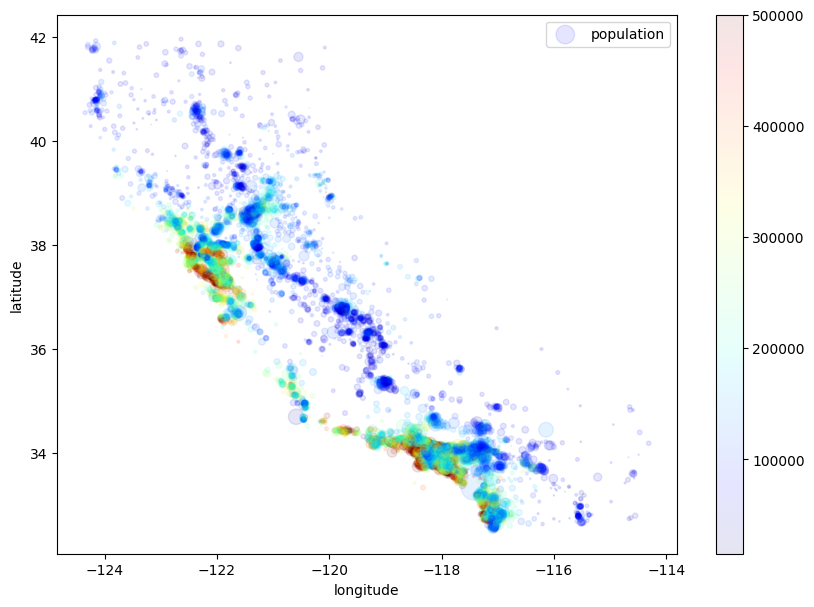

In [52]:
import matplotlib.pyplot as plt
housing.plot(kind="scatter",x="longitude",y="latitude",alpha=0.1,
            s=housing["population"]/100,label="population",figsize=(10,7),
             c=housing["median_house_value"],cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()

### 3. Data Preprocessing

- Train-test split first (to avoid leakage).
- Apply scaling to numeric features.
- Handle categorical features.

In [55]:
housing=strat_train_set.drop("median_house_value",axis=1)
housing_labels=strat_train_set["median_house_value"].copy()

In [56]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [57]:
housing_num = housing.drop("ocean_proximity", axis=1)

In [58]:
#filling the missing value
imputer.fit(housing_num)

,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False


In [59]:
X = imputer.transform(housing_num)

In [60]:
housing_tr=pd.DataFrame(X,columns=housing_num.columns,index=housing_num.index)

#### handling categorical features by OneHotEncoder

In [61]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


In [64]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder=OneHotEncoder()
housing_1hot=cat_encoder.fit_transform(housing_cat)
housing_1hot

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 16512 stored elements and shape (16512, 5)>

### Creating new features:
- Rooms per household
- Population per household
- Latitude-longitude binning

In [65]:

from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np  # Added import for np.c_

rooms_ix, bedrooms_ix, population_ix, households_ix = 4, 5, 6, 7

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):  # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Fixed indexing: Use X[:, index] instead of X[:index]
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        # Fixed variable name: populatuion_ix → population_ix and households → households_ix
        population_per_household = X[:, population_ix] / X[:, households_ix]
        
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            # Fixed variable names: rooms_per_household and population_per_household
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            # Fixed variable names: rooms_per_household and population_per_household
            return np.c_[X, rooms_per_household, population_per_household]
            
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

### Making numerical pipeline(transforming only numeric data)

In [66]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),])
housing_num_tr = num_pipeline.fit_transform(housing_num)

### full Pre-processing Pipeline

In [67]:
from sklearn.compose import ColumnTransformer

num_attribs=list(housing_num)
cat_attribs=["ocean_proximity"]

full_pipeline=ColumnTransformer([
    ("nums",num_pipeline,num_attribs),
    ("cat",OneHotEncoder(),cat_attribs),])
housing_prepared=full_pipeline.fit_transform(housing)

### extracting some data for testing 

In [73]:
# some prepared data to test
some_data=housing.iloc[:5]
some_labels=housing_labels.iloc[:5]

some_prepared_data=full_pipeline.transform(some_data)

In [74]:
# Separate features and labels
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

# Apply the pipeline to test features
X_test_prepared = full_pipeline.transform(X_test)

### fitting our first model: Linear Regression

In [70]:
from sklearn.linear_model import LinearRegression
lin_reg=LinearRegression()
lin_reg.fit(housing_prepared,housing_labels)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [78]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
test_predictions = lin_reg.predict(X_test_prepared)

lin_reg_mse = mean_squared_error(y_test, test_predictions)
lin_reg_rmse = np.sqrt(lin_reg_mse)
lin_reg_r2 = r2_score(y_test, test_predictions)

print(f"Test RMSE: {lin_reg_rmse:.2f}")
print(f"Test R-squared: {lin_reg_r2:.2f}")

Test RMSE: 67381.26
Test R-squared: 0.65


## XGBoost Regressor

In [80]:
import xgboost as xgb
from xgboost import XGBRegressor 

In [86]:
model=XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)
model.fit(housing_prepared,housing_labels)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [87]:
test_predictions = model.predict(X_test_prepared)

xg_boost_mse = mean_squared_error(y_test, test_predictions)
xg_boost_rmse = np.sqrt(xg_boost_mse)
xg_boost_r2 = r2_score(y_test, test_predictions)

print(f"Test RMSE: {xg_boost_rmse:.2f}")
print(f"Test R-squared: {xg_boost_r2:.2f}")

Test RMSE: 47311.49
Test R-squared: 0.83


### R2 score has increased and the rmse value went down
### but is it correct  or the model is overfitting?
## Cross Validation:

In [88]:
from sklearn.model_selection import KFold, cross_val_score

#  Define the K-fold splits
k_folds = KFold(n_splits=5, shuffle=True, random_state=42)

#  Define the model
model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    objective='reg:squarederror'
)

scores = cross_val_score(model, housing_prepared,housing_labels, cv=k_folds, scoring='neg_mean_squared_error')

# 4. Calculate the average and standard deviation of the scores
rmse_scores = np.sqrt(-scores)
print(f"RMSE scores for each fold: {np.round(rmse_scores, 2)}")
print(f"Average RMSE: {rmse_scores.mean():.2f}")
print(f"Standard Deviation of RMSE: {rmse_scores.std():.2f}")

RMSE scores for each fold: [48510.86 50362.69 49748.69 51360.87 47796.16]
Average RMSE: 49555.85
Standard Deviation of RMSE: 1275.52


In [96]:
import xgboost as xgb
dtrain = xgb.DMatrix(housing_prepared, label=housing_labels)
params={
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "learning_rate":0.1,
    "max_depth":5,
}
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=2000,   # give it more rounds
    nfold=5,
    metrics="rmse",
    seed=42,
    shuffle=True,
    early_stopping_rounds=100  # ⬅️ this is important
)

print(cv_results)
print("Best CV RMSE:", cv_results["test-rmse-mean"].min())
print("Best boosting round:", cv_results["test-rmse-mean"].idxmin())

     train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0      108104.237783      257.925066   108248.444774    1052.915713
1      101418.787620      276.588761   101669.793774    1052.220920
2       95533.209964      232.506629    95915.278501    1079.409251
3       90348.366279      246.816106    90853.993701    1118.129125
4       85842.377717      223.743535    86472.665485    1152.478860
..               ...             ...             ...            ...
967     18952.565897      192.884037    47022.406307    1247.048588
968     18936.942402      198.157440    47018.780156    1246.089858
969     18923.595032      195.027267    47021.272567    1244.254950
970     18909.827935      196.384709    47019.142013    1243.592397
971     18897.589011      199.682651    47016.544901    1243.258508

[972 rows x 4 columns]
Best CV RMSE: 47016.54490138988
Best boosting round: 971


### train rmse: 18897 and test rmse: 47016
#### difference between train and test RMSE is approx 30k which means ,the model is still Overfitting. 

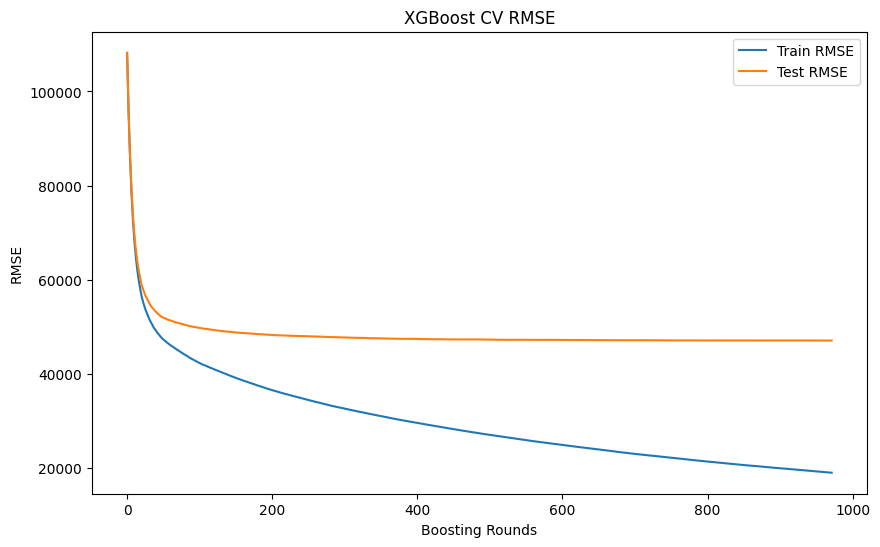

In [97]:
results = cv_results  # your DataFrame
results[['train-rmse-mean', 'test-rmse-mean']].plot(figsize=(10,6))
plt.title("XGBoost CV RMSE")
plt.xlabel("Boosting Rounds")
plt.ylabel("RMSE")
plt.legend(["Train RMSE", "Test RMSE"])
plt.show()

### XGBoost hyper parameters tunning by optuna 
### Minimizing RMSE

In [126]:
import optuna
from sklearn.metrics import r2_score
def objective(trial):
    params = {
        'verbosity': 0,
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'booster': 'gbtree',
        'tree_method': 'gpu_hist',
        'n_estimators': trial.suggest_int('n_estimators', 100,1500),
        'max_depth': trial.suggest_int('max_depth', 3, 5),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'subsample': trial.suggest_float('subsample', 0.7, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 0.9),
        'min_child_weight': trial.suggest_float('min_child_weight',1,5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1.0, 5.0),
        'random_state': 42,
    }
    #passing the params for optuna
    optuna_model=XGBRegressor(**params)
    optuna_model.fit(housing_prepared,housing_labels)

    y_pred=optuna_model.predict(X_test_prepared)
    mse=mean_squared_error(y_test,y_pred)
    rmse=np.sqrt(mse)
    #return the evaluation metrics
    return rmse

#create study & optimize
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50,show_progress_bar=True)

[I 2025-09-02 23:40:52,430] A new study created in memory with name: no-name-9bcf20d6-0e07-4684-a092-921a90bac470
                                      

[I 2025-09-02 23:40:56,943] Trial 0 finished with value: 45209.05415932199 and parameters: {'n_estimators': 844, 'max_depth': 4, 'learning_rate': 0.06678748627305924, 'subsample': 0.7616333261785339, 'colsample_bytree': 0.8186751240375902, 'min_child_weight': 2.446874130381213, 'reg_alpha': 0.9104228370200976, 'reg_lambda': 3.3499143916158194}. Best is trial 0 with value: 45209.05415932199.


[I 2025-09-02 23:41:03,219] Trial 1 finished with value: 44968.849200197146 and parameters: {'n_estimators': 869, 'max_depth': 5, 'learning_rate': 0.0442636955535234, 'subsample': 0.7082149277898364, 'colsample_bytree': 0.7966360692237119, 'min_child_weight': 2.649882630483878, 'reg_alpha': 0.7672224425104157, 'reg_lambda': 1.9142387914217731}. Best is trial 1 with value: 44968.849200197146.


[I 2025-09-02 23:41:09,697] Trial 2 finished with value: 49683.48705941034 and parameters: {'n_estimators': 1334, 'max_depth': 3, 'learning_rate': 0.015481229621606063, 'subsample': 0.7140551541575486, 'colsample_bytree': 0.8038127255460116, 'min_child_weight': 1.898204177608219, 'reg_alpha': 0.5750705291242254, 'reg_lambda': 1.4605985682631446}. Best is trial 1 with value: 44968.849200197146.


[I 2025-09-02 23:41:15,085] Trial 3 finished with value: 45258.03448162874 and parameters: {'n_estimators': 561, 'max_depth': 5, 'learning_rate': 0.06294367346832362, 'subsample': 0.8258747143405776, 'colsample_bytree': 0.7278817158741255, 'min_child_weight': 4.215426570998663, 'reg_alpha': 0.6015031535884492, 'reg_lambda': 1.1906398848462212}. Best is trial 1 with value: 44968.849200197146.


[I 2025-09-02 23:41:20,549] Trial 4 finished with value: 47719.86995867794 and parameters: {'n_estimators': 664, 'max_depth': 5, 'learning_rate': 0.01474092385361984, 'subsample': 0.8512961242736512, 'colsample_bytree': 0.7458551665819593, 'min_child_weight': 3.0965360350195796, 'reg_alpha': 0.9680865084552871, 'reg_lambda': 4.276033571390925}. Best is trial 1 with value: 44968.849200197146.


[I 2025-09-02 23:41:25,904] Trial 5 finished with value: 46667.0979541367 and parameters: {'n_estimators': 800, 'max_depth': 3, 'learning_rate': 0.09734014831430221, 'subsample': 0.7238701132517688, 'colsample_bytree': 0.828381480795535, 'min_child_weight': 1.7389899498170736, 'reg_alpha': 0.9709214988394465, 'reg_lambda': 1.788981951095015}. Best is trial 1 with value: 44968.849200197146.


[I 2025-09-02 23:41:31,733] Trial 6 finished with value: 47536.05236606414 and parameters: {'n_estimators': 724, 'max_depth': 4, 'learning_rate': 0.023759931945596387, 'subsample': 0.8116942915736809, 'colsample_bytree': 0.884630571111088, 'min_child_weight': 2.7264230035372004, 'reg_alpha': 0.5802402820068312, 'reg_lambda': 2.6222284011675137}. Best is trial 1 with value: 44968.849200197146.


[I 2025-09-02 23:41:35,558] Trial 7 finished with value: 61062.84488893718 and parameters: {'n_estimators': 114, 'max_depth': 3, 'learning_rate': 0.026802842797888044, 'subsample': 0.8184077043726405, 'colsample_bytree': 0.740520892910489, 'min_child_weight': 1.3332506683048373, 'reg_alpha': 0.8138599126023432, 'reg_lambda': 4.87409414622723}. Best is trial 1 with value: 44968.849200197146.


[I 2025-09-02 23:41:43,206] Trial 8 finished with value: 45759.86482435547 and parameters: {'n_estimators': 1252, 'max_depth': 5, 'learning_rate': 0.016050795637434723, 'subsample': 0.8595476338813184, 'colsample_bytree': 0.8026048629840948, 'min_child_weight': 2.073101464046029, 'reg_alpha': 0.27179667275079056, 'reg_lambda': 4.5854837838310765}. Best is trial 1 with value: 44968.849200197146.


[I 2025-09-02 23:41:48,656] Trial 9 finished with value: 47484.90097394283 and parameters: {'n_estimators': 876, 'max_depth': 3, 'learning_rate': 0.06117366254340417, 'subsample': 0.7639245552191716, 'colsample_bytree': 0.812536291846256, 'min_child_weight': 2.016129836760673, 'reg_alpha': 0.1925872129366053, 'reg_lambda': 1.6782437124121552}. Best is trial 1 with value: 44968.849200197146.


[I 2025-09-02 23:41:55,523] Trial 10 finished with value: 44678.44409303593 and parameters: {'n_estimators': 1104, 'max_depth': 5, 'learning_rate': 0.03943989500902327, 'subsample': 0.7592314403840799, 'colsample_bytree': 0.8626714143233915, 'min_child_weight': 3.6369028345194554, 'reg_alpha': 0.008963177817291668, 'reg_lambda': 2.6215742155451576}. Best is trial 10 with value: 44678.44409303593.


[I 2025-09-02 23:42:03,104] Trial 11 finished with value: 44628.25163249997 and parameters: {'n_estimators': 1123, 'max_depth': 5, 'learning_rate': 0.040992649855426916, 'subsample': 0.7538363509331187, 'colsample_bytree': 0.8706735341259073, 'min_child_weight': 3.6500496441211165, 'reg_alpha': 0.01596347044042363, 'reg_lambda': 2.736693730908846}. Best is trial 11 with value: 44628.25163249997.


[I 2025-09-02 23:42:10,227] Trial 12 finished with value: 45474.54209119163 and parameters: {'n_estimators': 1120, 'max_depth': 4, 'learning_rate': 0.03791860052133973, 'subsample': 0.7657155515622831, 'colsample_bytree': 0.8978590490836325, 'min_child_weight': 3.772616669140233, 'reg_alpha': 0.04534304126708188, 'reg_lambda': 2.950849214470117}. Best is trial 11 with value: 44628.25163249997.


[I 2025-09-02 23:42:18,863] Trial 13 finished with value: 43963.673045804266 and parameters: {'n_estimators': 1478, 'max_depth': 5, 'learning_rate': 0.042520018327112094, 'subsample': 0.8922379754622389, 'colsample_bytree': 0.8579307904586742, 'min_child_weight': 4.985088474655348, 'reg_alpha': 0.030344755221806893, 'reg_lambda': 3.5869424599464614}. Best is trial 13 with value: 43963.673045804266.


[I 2025-09-02 23:42:27,263] Trial 14 finished with value: 44657.050804389735 and parameters: {'n_estimators': 1474, 'max_depth': 5, 'learning_rate': 0.021952055594396034, 'subsample': 0.8725934807559296, 'colsample_bytree': 0.8505053425694791, 'min_child_weight': 4.8334817349307615, 'reg_alpha': 0.34504797541531995, 'reg_lambda': 3.7245323995447244}. Best is trial 13 with value: 43963.673045804266.


[I 2025-09-02 23:42:35,340] Trial 15 finished with value: 47985.44077743321 and parameters: {'n_estimators': 1449, 'max_depth': 4, 'learning_rate': 0.01026750025663119, 'subsample': 0.8993467104294208, 'colsample_bytree': 0.8586973502815501, 'min_child_weight': 4.959126132065268, 'reg_alpha': 0.12220943566650336, 'reg_lambda': 3.6956921068318356}. Best is trial 13 with value: 43963.673045804266.


[I 2025-09-02 23:42:42,911] Trial 16 finished with value: 44645.53025020851 and parameters: {'n_estimators': 1122, 'max_depth': 5, 'learning_rate': 0.04910282884390877, 'subsample': 0.7865418306628935, 'colsample_bytree': 0.770402123030166, 'min_child_weight': 4.30622059357129, 'reg_alpha': 0.38975239106372533, 'reg_lambda': 2.2798078570947076}. Best is trial 13 with value: 43963.673045804266.


[I 2025-09-02 23:42:50,344] Trial 17 finished with value: 45795.36964971065 and parameters: {'n_estimators': 1256, 'max_depth': 4, 'learning_rate': 0.031379027796527924, 'subsample': 0.737825688880275, 'colsample_bytree': 0.8749716861811944, 'min_child_weight': 3.3493280425945984, 'reg_alpha': 0.17172404118208917, 'reg_lambda': 4.002047698238599}. Best is trial 13 with value: 43963.673045804266.


[I 2025-09-02 23:42:57,254] Trial 18 finished with value: 43988.54972741562 and parameters: {'n_estimators': 1015, 'max_depth': 5, 'learning_rate': 0.08928241597865355, 'subsample': 0.8939594794788218, 'colsample_bytree': 0.843673819447664, 'min_child_weight': 4.390499799319184, 'reg_alpha': 0.004196138640223612, 'reg_lambda': 3.225921868727163}. Best is trial 13 with value: 43963.673045804266.


[I 2025-09-02 23:43:01,770] Trial 19 finished with value: 46299.00172247206 and parameters: {'n_estimators': 336, 'max_depth': 4, 'learning_rate': 0.09934283216461386, 'subsample': 0.8969047717107531, 'colsample_bytree': 0.8411602680481096, 'min_child_weight': 4.420977174823664, 'reg_alpha': 0.44596397150871103, 'reg_lambda': 3.5023528233329366}. Best is trial 13 with value: 43963.673045804266.


[I 2025-09-02 23:43:08,932] Trial 20 finished with value: 44568.97971465588 and parameters: {'n_estimators': 990, 'max_depth': 5, 'learning_rate': 0.07291120839238617, 'subsample': 0.8844261992189006, 'colsample_bytree': 0.7000084551641639, 'min_child_weight': 4.633222315858947, 'reg_alpha': 0.27708174771599614, 'reg_lambda': 3.185581788479918}. Best is trial 13 with value: 43963.673045804266.


[I 2025-09-02 23:43:15,811] Trial 21 finished with value: 44455.0758091705 and parameters: {'n_estimators': 986, 'max_depth': 5, 'learning_rate': 0.07892238802091694, 'subsample': 0.8821125880871113, 'colsample_bytree': 0.7771051614312947, 'min_child_weight': 4.597069463093519, 'reg_alpha': 0.26785371943744823, 'reg_lambda': 3.2035212485228524}. Best is trial 13 with value: 43963.673045804266.


[I 2025-09-02 23:43:21,624] Trial 22 finished with value: 44898.351144974935 and parameters: {'n_estimators': 546, 'max_depth': 5, 'learning_rate': 0.08079039028683503, 'subsample': 0.8453374526995096, 'colsample_bytree': 0.7725523350659804, 'min_child_weight': 4.083819249114063, 'reg_alpha': 0.11165047831813467, 'reg_lambda': 4.124033691935097}. Best is trial 13 with value: 43963.673045804266.


[I 2025-09-02 23:43:28,404] Trial 23 finished with value: 44490.51766802436 and parameters: {'n_estimators': 944, 'max_depth': 5, 'learning_rate': 0.052609539435607915, 'subsample': 0.8744420846156964, 'colsample_bytree': 0.8384145468731392, 'min_child_weight': 4.586540640604222, 'reg_alpha': 0.2702878475015248, 'reg_lambda': 3.0337332271603974}. Best is trial 13 with value: 43963.673045804266.


[I 2025-09-02 23:43:36,035] Trial 24 finished with value: 44539.5714897927 and parameters: {'n_estimators': 1009, 'max_depth': 5, 'learning_rate': 0.08605012093321089, 'subsample': 0.835251336980111, 'colsample_bytree': 0.7828289402865151, 'min_child_weight': 4.973693000439129, 'reg_alpha': 0.10472268849381211, 'reg_lambda': 2.252867361063137}. Best is trial 13 with value: 43963.673045804266.


[I 2025-09-02 23:43:43,661] Trial 25 finished with value: 44745.59536570627 and parameters: {'n_estimators': 1343, 'max_depth': 4, 'learning_rate': 0.054702955161003326, 'subsample': 0.8739884305104045, 'colsample_bytree': 0.8268788531935243, 'min_child_weight': 4.017628395006594, 'reg_alpha': 0.21148643817106133, 'reg_lambda': 3.753362812414264}. Best is trial 13 with value: 43963.673045804266.


[I 2025-09-02 23:43:52,051] Trial 26 finished with value: 44120.31117408317 and parameters: {'n_estimators': 1224, 'max_depth': 5, 'learning_rate': 0.08092505107557729, 'subsample': 0.887102984598213, 'colsample_bytree': 0.7865524634224361, 'min_child_weight': 4.667375534907128, 'reg_alpha': 0.07527361763770785, 'reg_lambda': 3.3968927837460416}. Best is trial 13 with value: 43963.673045804266.


[I 2025-09-02 23:44:00,568] Trial 27 finished with value: 44183.066018843216 and parameters: {'n_estimators': 1369, 'max_depth': 5, 'learning_rate': 0.03245998550902704, 'subsample': 0.8607378731329777, 'colsample_bytree': 0.846994679300511, 'min_child_weight': 3.8564912331650656, 'reg_alpha': 0.07080530839924792, 'reg_lambda': 3.418909083838373}. Best is trial 13 with value: 43963.673045804266.


[I 2025-09-02 23:44:08,363] Trial 28 finished with value: 44270.348978557355 and parameters: {'n_estimators': 1240, 'max_depth': 5, 'learning_rate': 0.05910840152720508, 'subsample': 0.7887777257518431, 'colsample_bytree': 0.7577784156563447, 'min_child_weight': 4.710287571801504, 'reg_alpha': 0.15471845463593456, 'reg_lambda': 4.44921342317135}. Best is trial 13 with value: 43963.673045804266.


[I 2025-09-02 23:44:16,036] Trial 29 finished with value: 44565.51563861723 and parameters: {'n_estimators': 1194, 'max_depth': 4, 'learning_rate': 0.06935940137548448, 'subsample': 0.8880692362180755, 'colsample_bytree': 0.8165606376665187, 'min_child_weight': 4.430568463966134, 'reg_alpha': 0.011100746284787709, 'reg_lambda': 3.9284417631937036}. Best is trial 13 with value: 43963.673045804266.


[I 2025-09-02 23:44:23,666] Trial 30 finished with value: 44379.1750983199 and parameters: {'n_estimators': 1397, 'max_depth': 4, 'learning_rate': 0.08734667286169556, 'subsample': 0.8636127221562767, 'colsample_bytree': 0.8870812280862345, 'min_child_weight': 3.3931444235213926, 'reg_alpha': 0.07880528207933735, 'reg_lambda': 3.5283523232793628}. Best is trial 13 with value: 43963.673045804266.


[I 2025-09-02 23:44:31,575] Trial 31 finished with value: 44528.56889483342 and parameters: {'n_estimators': 1335, 'max_depth': 5, 'learning_rate': 0.03418249477494894, 'subsample': 0.8990631064515969, 'colsample_bytree': 0.8430215597617675, 'min_child_weight': 3.9380142772259896, 'reg_alpha': 0.0771701573158658, 'reg_lambda': 3.3888799307241264}. Best is trial 13 with value: 43963.673045804266.


[I 2025-09-02 23:44:41,491] Trial 32 finished with value: 43927.07865934766 and parameters: {'n_estimators': 1491, 'max_depth': 5, 'learning_rate': 0.04652370728061004, 'subsample': 0.8632559268063255, 'colsample_bytree': 0.7901045161343254, 'min_child_weight': 4.366113313282658, 'reg_alpha': 0.0018327330796313532, 'reg_lambda': 3.0092736465129306}. Best is trial 32 with value: 43927.07865934766.


[I 2025-09-02 23:44:50,299] Trial 33 finished with value: 44042.39145935364 and parameters: {'n_estimators': 1490, 'max_depth': 5, 'learning_rate': 0.048000871601705915, 'subsample': 0.847087981288619, 'colsample_bytree': 0.7939710211143289, 'min_child_weight': 4.383932870663534, 'reg_alpha': 0.0006243190456433623, 'reg_lambda': 2.892480043330794}. Best is trial 32 with value: 43927.07865934766.


[I 2025-09-02 23:44:59,045] Trial 34 finished with value: 43986.54564422943 and parameters: {'n_estimators': 1499, 'max_depth': 5, 'learning_rate': 0.04775949180466221, 'subsample': 0.8392491444441045, 'colsample_bytree': 0.7914872979240144, 'min_child_weight': 4.272982649611453, 'reg_alpha': 0.20849061456815676, 'reg_lambda': 2.2483289106175954}. Best is trial 32 with value: 43927.07865934766.


[I 2025-09-02 23:45:07,618] Trial 35 finished with value: 43995.5216624376 and parameters: {'n_estimators': 1497, 'max_depth': 5, 'learning_rate': 0.04485945555756584, 'subsample': 0.836724092736243, 'colsample_bytree': 0.8097998801067978, 'min_child_weight': 4.2256037080002455, 'reg_alpha': 0.22252805250653918, 'reg_lambda': 2.3176223733452908}. Best is trial 32 with value: 43927.07865934766.


[I 2025-09-02 23:45:16,449] Trial 36 finished with value: 44422.9399840423 and parameters: {'n_estimators': 1396, 'max_depth': 5, 'learning_rate': 0.02776001954468232, 'subsample': 0.868275133419728, 'colsample_bytree': 0.8262120564432128, 'min_child_weight': 3.4248131626530705, 'reg_alpha': 0.6895327325767492, 'reg_lambda': 1.0791233101364397}. Best is trial 32 with value: 43927.07865934766.


[I 2025-09-02 23:45:25,065] Trial 37 finished with value: 44352.116528737795 and parameters: {'n_estimators': 1303, 'max_depth': 5, 'learning_rate': 0.03685544007101527, 'subsample': 0.8553513119580051, 'colsample_bytree': 0.7617233195564471, 'min_child_weight': 2.9653436015940904, 'reg_alpha': 0.5001206727674854, 'reg_lambda': 2.108903252491963}. Best is trial 32 with value: 43927.07865934766.


[I 2025-09-02 23:45:33,581] Trial 38 finished with value: 44124.575185959424 and parameters: {'n_estimators': 1418, 'max_depth': 5, 'learning_rate': 0.05589440167987596, 'subsample': 0.8053201947344109, 'colsample_bytree': 0.8002824924779623, 'min_child_weight': 4.154163620848006, 'reg_alpha': 0.3541168720238411, 'reg_lambda': 2.6041696280423}. Best is trial 32 with value: 43927.07865934766.


[I 2025-09-02 23:45:39,421] Trial 39 finished with value: 47023.849055406245 and parameters: {'n_estimators': 573, 'max_depth': 5, 'learning_rate': 0.020533804001321387, 'subsample': 0.8419218680705265, 'colsample_bytree': 0.8333782039672888, 'min_child_weight': 2.445889355494504, 'reg_alpha': 0.14964611094772787, 'reg_lambda': 1.5240805876496428}. Best is trial 32 with value: 43927.07865934766.


[I 2025-09-02 23:45:45,383] Trial 40 finished with value: 49699.704606158404 and parameters: {'n_estimators': 714, 'max_depth': 3, 'learning_rate': 0.028876621281239894, 'subsample': 0.8251098857261981, 'colsample_bytree': 0.793564613420171, 'min_child_weight': 4.800447148045685, 'reg_alpha': 0.8538515865551133, 'reg_lambda': 2.4368518376448263}. Best is trial 32 with value: 43927.07865934766.


[I 2025-09-02 23:45:53,726] Trial 41 finished with value: 44171.93707990855 and parameters: {'n_estimators': 1498, 'max_depth': 5, 'learning_rate': 0.04562914341096429, 'subsample': 0.8319514470740462, 'colsample_bytree': 0.8108121733994531, 'min_child_weight': 4.100894405413734, 'reg_alpha': 0.20048799497177097, 'reg_lambda': 1.9378327239400672}. Best is trial 32 with value: 43927.07865934766.


[I 2025-09-02 23:46:02,748] Trial 42 finished with value: 44040.32677488093 and parameters: {'n_estimators': 1431, 'max_depth': 5, 'learning_rate': 0.04370390617757186, 'subsample': 0.8546735303201549, 'colsample_bytree': 0.8082537629711407, 'min_child_weight': 4.296506432526563, 'reg_alpha': 0.04723195702280214, 'reg_lambda': 3.1284280330317076}. Best is trial 32 with value: 43927.07865934766.


[I 2025-09-02 23:46:10,457] Trial 43 finished with value: 44173.972716698256 and parameters: {'n_estimators': 1313, 'max_depth': 5, 'learning_rate': 0.06659443826977647, 'subsample': 0.8163250305470078, 'colsample_bytree': 0.8214950782414822, 'min_child_weight': 4.550920503163422, 'reg_alpha': 0.24352116801408394, 'reg_lambda': 2.7267504435624925}. Best is trial 32 with value: 43927.07865934766.


[I 2025-09-02 23:46:18,972] Trial 44 finished with value: 43870.17964166952 and parameters: {'n_estimators': 1492, 'max_depth': 5, 'learning_rate': 0.042490238881943476, 'subsample': 0.8797596877484558, 'colsample_bytree': 0.8570386065203646, 'min_child_weight': 3.6286700117507746, 'reg_alpha': 0.31264018547499095, 'reg_lambda': 2.407344975721481}. Best is trial 44 with value: 43870.17964166952.


[I 2025-09-02 23:46:23,859] Trial 45 finished with value: 46328.731075105956 and parameters: {'n_estimators': 411, 'max_depth': 5, 'learning_rate': 0.036445383778417606, 'subsample': 0.8797152902970292, 'colsample_bytree': 0.8605756841928578, 'min_child_weight': 3.7641929909151446, 'reg_alpha': 0.33869308571948387, 'reg_lambda': 2.0056549738764637}. Best is trial 44 with value: 43870.17964166952.


[I 2025-09-02 23:46:28,013] Trial 46 finished with value: 50481.56347481082 and parameters: {'n_estimators': 112, 'max_depth': 5, 'learning_rate': 0.041472072352846834, 'subsample': 0.8677949601586603, 'colsample_bytree': 0.8770955885266749, 'min_child_weight': 3.6151420266471153, 'reg_alpha': 0.13643076051282702, 'reg_lambda': 2.8762401488254574}. Best is trial 44 with value: 43870.17964166952.


[I 2025-09-02 23:46:35,575] Trial 47 finished with value: 44089.24767655758 and parameters: {'n_estimators': 1174, 'max_depth': 5, 'learning_rate': 0.05004741664707743, 'subsample': 0.8912875257807773, 'colsample_bytree': 0.8519376549687463, 'min_child_weight': 4.976691690526754, 'reg_alpha': 0.4696871081617378, 'reg_lambda': 2.5152100469047576}. Best is trial 44 with value: 43870.17964166952.


[I 2025-09-02 23:46:43,500] Trial 48 finished with value: 44645.84336908329 and parameters: {'n_estimators': 1276, 'max_depth': 5, 'learning_rate': 0.025396447994301026, 'subsample': 0.8791891085857167, 'colsample_bytree': 0.8890009185620403, 'min_child_weight': 1.1554146808294223, 'reg_alpha': 0.30832304611920347, 'reg_lambda': 1.7221915229312028}. Best is trial 44 with value: 43870.17964166952.


[I 2025-09-02 23:46:50,961] Trial 49 finished with value: 44770.18543768218 and parameters: {'n_estimators': 1057, 'max_depth': 4, 'learning_rate': 0.0640329778697429, 'subsample': 0.8910227544253032, 'colsample_bytree': 0.8666117654099572, 'min_child_weight': 3.106083772533202, 'reg_alpha': 0.5349911478561524, 'reg_lambda': 1.3150503768779693}. Best is trial 44 with value: 43870.17964166952.


Best trial: 44. Best value: 43870.2: 100%|██████████| 50/50 [05:58<00:00,  7.17s/it]


In [127]:
# Print the best hyperparameters and value
print(f"Best RMSE: {study.best_value}")
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

Best RMSE: 43870.17964166952
Number of finished trials: 50
Best trial: {'n_estimators': 1492, 'max_depth': 5, 'learning_rate': 0.042490238881943476, 'subsample': 0.8797596877484558, 'colsample_bytree': 0.8570386065203646, 'min_child_weight': 3.6286700117507746, 'reg_alpha': 0.31264018547499095, 'reg_lambda': 2.407344975721481}


In [128]:
print(study.best_params)

{'n_estimators': 1492, 'max_depth': 5, 'learning_rate': 0.042490238881943476, 'subsample': 0.8797596877484558, 'colsample_bytree': 0.8570386065203646, 'min_child_weight': 3.6286700117507746, 'reg_alpha': 0.31264018547499095, 'reg_lambda': 2.407344975721481}


## xgboost: cross validation 

In [130]:
import xgboost as xgb
import numpy as np

dtrain = xgb.DMatrix(housing_prepared, label=housing_labels)

params = study.best_params.copy()
params.update({
    "objective": "reg:squarederror",
    "eval_metric": "rmse"
})
params.pop('n_estimators')

cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=3000,   # give it more rounds
    nfold=5,
    metrics="rmse",
    seed=42,
    shuffle=True,
    early_stopping_rounds=100  # ⬅️ this is important
)

print(cv_results)
print("Best CV RMSE:", cv_results["test-rmse-mean"].min())
print("Best boosting round:", cv_results["test-rmse-mean"].idxmin())

      train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0       112590.536962      250.465945   112637.145978    1094.771813
1       109506.322786      244.296717   109587.496056    1103.875421
2       107206.366817      228.523683   107347.097655    1090.047542
3       104399.434833      215.256320   104595.465324    1101.024740
4       102412.665852      237.180586   102628.055814    1061.465299
...               ...             ...             ...            ...
2704     17542.321327      112.451954    46158.489215    1056.092401
2705     17538.169684      112.281411    46158.117321    1055.474679
2706     17532.872904      112.547476    46158.283020    1055.677222
2707     17527.366157      112.387588    46157.516630    1056.811263
2708     17522.169308      111.860147    46157.467920    1057.330129

[2709 rows x 4 columns]
Best CV RMSE: 46157.4679203162
Best boosting round: 2708


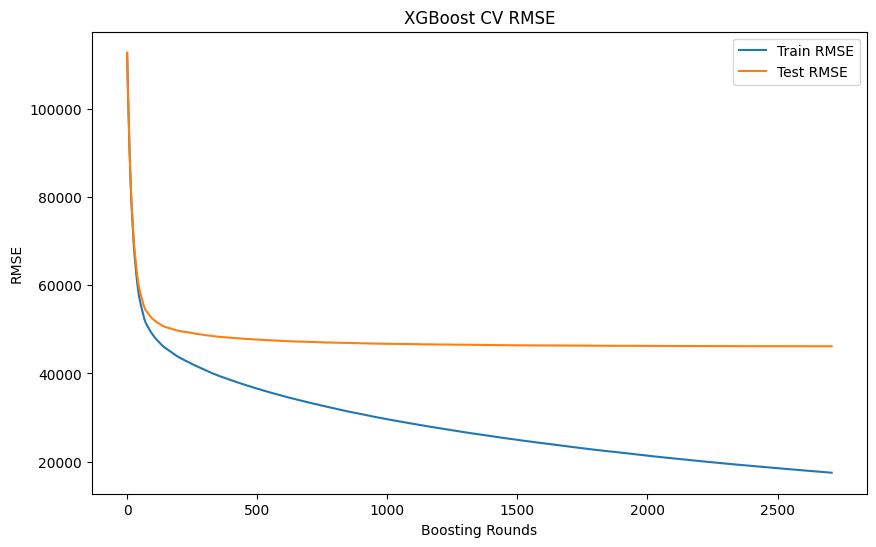

In [131]:
results = cv_results  # your DataFrame
results[['train-rmse-mean', 'test-rmse-mean']].plot(figsize=(10,6))
plt.title("XGBoost CV RMSE")
plt.xlabel("Boosting Rounds")
plt.ylabel("RMSE")
plt.legend(["Train RMSE", "Test RMSE"])
plt.show()

## Optuna comes with some good visualizer functions:

In [132]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_colsample_bytree,params_learning_rate,params_max_depth,params_min_child_weight,params_n_estimators,params_reg_alpha,params_reg_lambda,params_subsample,state
0,0,45209.054159,2025-09-02 23:40:52.437995,2025-09-02 23:40:56.943261,0 days 00:00:04.505266,0.818675,0.066787,4,2.446874,844,0.910423,3.349914,0.761633,COMPLETE
1,1,44968.849200,2025-09-02 23:40:57.236453,2025-09-02 23:41:03.219639,0 days 00:00:05.983186,0.796636,0.044264,5,2.649883,869,0.767222,1.914239,0.708215,COMPLETE
2,2,49683.487059,2025-09-02 23:41:03.626573,2025-09-02 23:41:09.697909,0 days 00:00:06.071336,0.803813,0.015481,3,1.898204,1334,0.575071,1.460599,0.714055,COMPLETE
3,3,45258.034482,2025-09-02 23:41:10.246670,2025-09-02 23:41:15.085932,0 days 00:00:04.839262,0.727882,0.062944,5,4.215427,561,0.601503,1.190640,0.825875,COMPLETE
4,4,47719.869959,2025-09-02 23:41:15.553910,2025-09-02 23:41:20.548717,0 days 00:00:04.994807,0.745855,0.014741,5,3.096536,664,0.968087,4.276034,0.851296,COMPLETE
5,5,46667.097954,2025-09-02 23:41:21.022823,2025-09-02 23:41:25.903622,0 days 00:00:04.880799,0.828381,0.097340,3,1.738990,800,0.970921,1.788982,0.723870,COMPLETE
6,6,47536.052366,2025-09-02 23:41:26.400261,2025-09-02 23:41:31.733482,0 days 00:00:05.333221,0.884631,0.023760,4,2.726423,724,0.580240,2.622228,0.811694,COMPLETE
7,7,61062.844889,2025-09-02 23:41:32.274129,2025-09-02 23:41:35.558427,0 days 00:00:03.284298,0.740521,0.026803,3,1.333251,114,0.813860,4.874094,0.818408,COMPLETE
8,8,45759.864824,2025-09-02 23:41:36.054213,2025-09-02 23:41:43.206737,0 days 00:00:07.152524,0.802605,0.016051,5,2.073101,1252,0.271797,4.585484,0.859548,COMPLETE
9,9,47484.900974,2025-09-02 23:41:43.706446,2025-09-02 23:41:48.656170,0 days 00:00:04.949724,0.812536,0.061174,3,2.016130,876,0.192587,1.678244,0.763925,COMPLETE


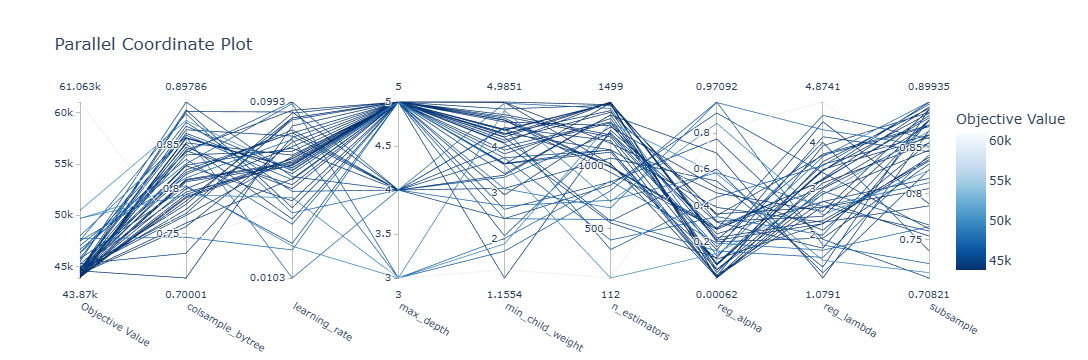

In [133]:
optuna.visualization.plot_parallel_coordinate(study)

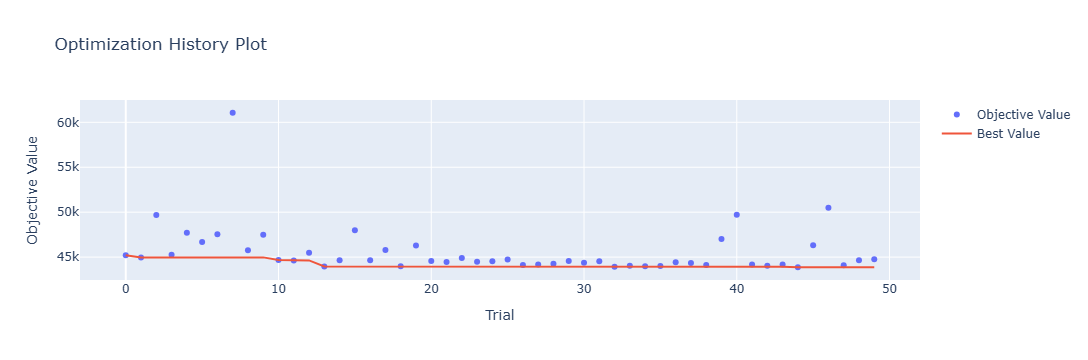

In [134]:
optuna.visualization.plot_optimization_history(study)

### we can see that how reg_lambda and n_estimators are important for our model

In [135]:
optuna.visualization.plot_param_importances(study)

## new & refine study on XGboost

In [145]:
best = study.best_params

def objective(trial):
    params = {
        'verbosity': 0,
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'booster': 'gbtree',
        'tree_method': 'gpu_hist',
        'n_estimator': 1910,
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'subsample': trial.suggest_float('subsample', 0.7, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 0.9),
        'min_child_weight': trial.suggest_float('min_child_weight',1,5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1.0, 5.0),
        'random_state': 42,
    }

    model = xgb.XGBRegressor(**params)
    model.fit(housing_prepared, housing_labels,
              eval_set=[(X_test_prepared, y_test)],
              verbose=False)
    
    preds = model.predict(X_test_prepared)
    mse = mean_squared_error(y_test, preds)
    rmse=np.sqrt(mse)
    return rmse

# Stage 2: fine-tune
refine_study = optuna.create_study(direction="minimize")
refine_study.optimize(objective_refine,show_progress_bar=True, n_trials=50)

print("Stage 2 Best params:", refine_study.best_params)


[I 2025-09-03 00:47:17,867] A new study created in memory with name: no-name-6b126128-89e0-4b71-b630-794a27ad664e
                                      

[I 2025-09-03 00:47:20,591] Trial 0 finished with value: 50063.36533381649 and parameters: {'learning_rate': 0.027449685553077054, 'max_depth': 7, 'subsample': 0.942494497591941, 'colsample_bytree': 0.9546587181162804, 'min_child_weight': 2, 'reg_lambda': 0.0011495241377559304, 'reg_alpha': 0.006559895001061806, 'max_bin': 315}. Best is trial 0 with value: 50063.36533381649.


[I 2025-09-03 00:47:24,905] Trial 1 finished with value: 49993.41353638426 and parameters: {'learning_rate': 0.028885873898624043, 'max_depth': 7, 'subsample': 0.8135259327658753, 'colsample_bytree': 0.8107040108765646, 'min_child_weight': 1, 'reg_lambda': 0.010684881644963843, 'reg_alpha': 0.035573352588217144, 'max_bin': 336}. Best is trial 1 with value: 49993.41353638426.


[I 2025-09-03 00:47:28,769] Trial 2 finished with value: 54117.88860225653 and parameters: {'learning_rate': 0.02230032267228867, 'max_depth': 6, 'subsample': 0.9354289935622877, 'colsample_bytree': 0.8131768945550129, 'min_child_weight': 3, 'reg_lambda': 0.009319627930609108, 'reg_alpha': 0.038104544382644025, 'max_bin': 277}. Best is trial 1 with value: 49993.41353638426.


[I 2025-09-03 00:47:32,507] Trial 3 finished with value: 57156.65638658796 and parameters: {'learning_rate': 0.02181403776643966, 'max_depth': 5, 'subsample': 0.9185914312252574, 'colsample_bytree': 0.9165187389309325, 'min_child_weight': 8, 'reg_lambda': 0.02121739475418225, 'reg_alpha': 0.07237570024106132, 'max_bin': 297}. Best is trial 1 with value: 49993.41353638426.


[I 2025-09-03 00:47:37,062] Trial 4 finished with value: 54488.128008766376 and parameters: {'learning_rate': 0.0274548120679478, 'max_depth': 5, 'subsample': 0.9662136398340306, 'colsample_bytree': 0.8034127426231656, 'min_child_weight': 8, 'reg_lambda': 0.0030253842275030393, 'reg_alpha': 0.008560352900676277, 'max_bin': 337}. Best is trial 1 with value: 49993.41353638426.


[I 2025-09-03 00:47:41,225] Trial 5 finished with value: 54065.19380914043 and parameters: {'learning_rate': 0.022586292032243976, 'max_depth': 6, 'subsample': 0.9488641247410221, 'colsample_bytree': 0.916027773004161, 'min_child_weight': 3, 'reg_lambda': 0.07314585554227007, 'reg_alpha': 0.02661501321452926, 'max_bin': 298}. Best is trial 1 with value: 49993.41353638426.


[I 2025-09-03 00:47:46,076] Trial 6 finished with value: 50183.026188397285 and parameters: {'learning_rate': 0.027745535352131263, 'max_depth': 7, 'subsample': 0.8189676162295892, 'colsample_bytree': 0.7940621346040403, 'min_child_weight': 2, 'reg_lambda': 0.007234507216509048, 'reg_alpha': 0.0011820704333087688, 'max_bin': 328}. Best is trial 1 with value: 49993.41353638426.


[I 2025-09-03 00:47:50,086] Trial 7 finished with value: 48686.47041162841 and parameters: {'learning_rate': 0.03351420688785357, 'max_depth': 7, 'subsample': 0.8658346836580342, 'colsample_bytree': 0.8463948963176597, 'min_child_weight': 6, 'reg_lambda': 0.054441756150221614, 'reg_alpha': 0.0270419892831098, 'max_bin': 325}. Best is trial 7 with value: 48686.47041162841.


[I 2025-09-03 00:47:54,957] Trial 8 finished with value: 53937.331066891544 and parameters: {'learning_rate': 0.02263542478297291, 'max_depth': 6, 'subsample': 0.9012603820719033, 'colsample_bytree': 0.8572628704418938, 'min_child_weight': 5, 'reg_lambda': 0.4668292272583259, 'reg_alpha': 0.0021239548772255786, 'max_bin': 306}. Best is trial 7 with value: 48686.47041162841.


[I 2025-09-03 00:47:58,986] Trial 9 finished with value: 53187.63619884244 and parameters: {'learning_rate': 0.03140852202891074, 'max_depth': 5, 'subsample': 0.9457488349411688, 'colsample_bytree': 0.8296317374665901, 'min_child_weight': 3, 'reg_lambda': 0.012789254263936825, 'reg_alpha': 0.14384766116203407, 'max_bin': 342}. Best is trial 7 with value: 48686.47041162841.


[I 2025-09-03 00:48:03,250] Trial 10 finished with value: 47730.00752070341 and parameters: {'learning_rate': 0.03910119797257294, 'max_depth': 7, 'subsample': 0.8628773494905535, 'colsample_bytree': 0.7684834693438762, 'min_child_weight': 6, 'reg_lambda': 0.12108478261623769, 'reg_alpha': 0.9334399052156276, 'max_bin': 250}. Best is trial 10 with value: 47730.00752070341.


[I 2025-09-03 00:48:07,251] Trial 11 finished with value: 47483.504525198296 and parameters: {'learning_rate': 0.041577244856861297, 'max_depth': 7, 'subsample': 0.859804548766935, 'colsample_bytree': 0.7614368223097059, 'min_child_weight': 6, 'reg_lambda': 0.10084079028550431, 'reg_alpha': 0.8913933669267732, 'max_bin': 252}. Best is trial 11 with value: 47483.504525198296.


[I 2025-09-03 00:48:11,438] Trial 12 finished with value: 47665.159599922656 and parameters: {'learning_rate': 0.04202670880284964, 'max_depth': 7, 'subsample': 0.8517243400573383, 'colsample_bytree': 0.7635824586565434, 'min_child_weight': 6, 'reg_lambda': 0.22751460282232908, 'reg_alpha': 0.9271201192721019, 'max_bin': 253}. Best is trial 11 with value: 47483.504525198296.


[I 2025-09-03 00:48:15,614] Trial 13 finished with value: 47487.85246294196 and parameters: {'learning_rate': 0.04215677852395153, 'max_depth': 7, 'subsample': 0.840066194864719, 'colsample_bytree': 0.7618634478215002, 'min_child_weight': 6, 'reg_lambda': 0.29343038934087734, 'reg_alpha': 0.7610122563859418, 'max_bin': 250}. Best is trial 11 with value: 47483.504525198296.


[I 2025-09-03 00:48:19,745] Trial 14 finished with value: 49901.29250676724 and parameters: {'learning_rate': 0.036281798124800084, 'max_depth': 6, 'subsample': 0.783737301683923, 'colsample_bytree': 0.7775117762030743, 'min_child_weight': 7, 'reg_lambda': 0.8540053759419014, 'reg_alpha': 0.3262907907440569, 'max_bin': 268}. Best is trial 11 with value: 47483.504525198296.


[I 2025-09-03 00:48:23,800] Trial 15 finished with value: 47554.28341594869 and parameters: {'learning_rate': 0.0406409051365192, 'max_depth': 7, 'subsample': 0.8352947937062221, 'colsample_bytree': 0.8749632588771631, 'min_child_weight': 5, 'reg_lambda': 0.21583329180891567, 'reg_alpha': 0.300455708004102, 'max_bin': 267}. Best is trial 11 with value: 47483.504525198296.


[I 2025-09-03 00:48:28,193] Trial 16 finished with value: 49584.68635676901 and parameters: {'learning_rate': 0.03724821042602398, 'max_depth': 6, 'subsample': 0.8929864082020308, 'colsample_bytree': 0.7591137092891184, 'min_child_weight': 7, 'reg_lambda': 0.3280874759592744, 'reg_alpha': 0.4357998989445012, 'max_bin': 278}. Best is trial 11 with value: 47483.504525198296.


[I 2025-09-03 00:48:32,215] Trial 17 finished with value: 48659.28176471192 and parameters: {'learning_rate': 0.03485454706364655, 'max_depth': 7, 'subsample': 0.7812637678421173, 'colsample_bytree': 0.787963163053429, 'min_child_weight': 4, 'reg_lambda': 0.05105345509170446, 'reg_alpha': 0.1505521806680002, 'max_bin': 263}. Best is trial 11 with value: 47483.504525198296.


[I 2025-09-03 00:48:36,544] Trial 18 finished with value: 48992.95338464482 and parameters: {'learning_rate': 0.042270468583842764, 'max_depth': 6, 'subsample': 0.8789741302771287, 'colsample_bytree': 0.885459720788963, 'min_child_weight': 7, 'reg_lambda': 0.7202282435765611, 'reg_alpha': 0.5803627011317875, 'max_bin': 284}. Best is trial 11 with value: 47483.504525198296.


[I 2025-09-03 00:48:40,757] Trial 19 finished with value: 48883.51666042277 and parameters: {'learning_rate': 0.03228067023975629, 'max_depth': 7, 'subsample': 0.8324330179883055, 'colsample_bytree': 0.8334243369542311, 'min_child_weight': 5, 'reg_lambda': 0.12098294684925412, 'reg_alpha': 0.14645729935740112, 'max_bin': 290}. Best is trial 11 with value: 47483.504525198296.


[I 2025-09-03 00:48:44,773] Trial 20 finished with value: 53073.52402640231 and parameters: {'learning_rate': 0.024877648166916073, 'max_depth': 6, 'subsample': 0.8044709625955793, 'colsample_bytree': 0.7822440088518567, 'min_child_weight': 4, 'reg_lambda': 0.02520738908614118, 'reg_alpha': 0.09578089684854589, 'max_bin': 258}. Best is trial 11 with value: 47483.504525198296.


[I 2025-09-03 00:48:48,654] Trial 21 finished with value: 47708.36698799145 and parameters: {'learning_rate': 0.03983054078334838, 'max_depth': 7, 'subsample': 0.8424266502103298, 'colsample_bytree': 0.8721185303613671, 'min_child_weight': 5, 'reg_lambda': 0.15985775992568976, 'reg_alpha': 0.2873313072643864, 'max_bin': 265}. Best is trial 11 with value: 47483.504525198296.


[I 2025-09-03 00:48:52,813] Trial 22 finished with value: 47949.15394112449 and parameters: {'learning_rate': 0.03913288174905469, 'max_depth': 7, 'subsample': 0.8284220984822558, 'colsample_bytree': 0.8777417850701674, 'min_child_weight': 6, 'reg_lambda': 0.33692163262180347, 'reg_alpha': 0.546496267417325, 'max_bin': 271}. Best is trial 11 with value: 47483.504525198296.


[I 2025-09-03 00:48:56,946] Trial 23 finished with value: 47230.00274969367 and parameters: {'learning_rate': 0.04239175932314939, 'max_depth': 7, 'subsample': 0.8518322301165956, 'colsample_bytree': 0.8986392378351058, 'min_child_weight': 5, 'reg_lambda': 0.08492717480246854, 'reg_alpha': 0.974882481545789, 'max_bin': 250}. Best is trial 23 with value: 47230.00274969367.


[I 2025-09-03 00:49:01,709] Trial 24 finished with value: 48139.60436261856 and parameters: {'learning_rate': 0.037194697081953595, 'max_depth': 7, 'subsample': 0.8703879947561793, 'colsample_bytree': 0.9051059502451618, 'min_child_weight': 7, 'reg_lambda': 0.08338721010876932, 'reg_alpha': 0.7081912520159463, 'max_bin': 250}. Best is trial 23 with value: 47230.00274969367.


[I 2025-09-03 00:49:05,676] Trial 25 finished with value: 47617.23553140674 and parameters: {'learning_rate': 0.04220163474849323, 'max_depth': 7, 'subsample': 0.8506920932874676, 'colsample_bytree': 0.9433586434832817, 'min_child_weight': 4, 'reg_lambda': 0.03645709103147236, 'reg_alpha': 0.272473565557083, 'max_bin': 258}. Best is trial 23 with value: 47230.00274969367.


[I 2025-09-03 00:49:09,849] Trial 26 finished with value: 48116.899721804 and parameters: {'learning_rate': 0.03798904478897837, 'max_depth': 7, 'subsample': 0.8914101195222504, 'colsample_bytree': 0.8987783184000769, 'min_child_weight': 6, 'reg_lambda': 0.5611623062659911, 'reg_alpha': 0.961186304505699, 'max_bin': 275}. Best is trial 23 with value: 47230.00274969367.


[I 2025-09-03 00:49:14,010] Trial 27 finished with value: 50124.65830114993 and parameters: {'learning_rate': 0.035020317421626534, 'max_depth': 6, 'subsample': 0.8534226217401636, 'colsample_bytree': 0.9363637636051759, 'min_child_weight': 5, 'reg_lambda': 0.08667355799575233, 'reg_alpha': 0.4679371233819665, 'max_bin': 257}. Best is trial 23 with value: 47230.00274969367.


[I 2025-09-03 00:49:18,075] Trial 28 finished with value: 47641.298889447906 and parameters: {'learning_rate': 0.040730009830681556, 'max_depth': 7, 'subsample': 0.8074748921054992, 'colsample_bytree': 0.828390196355338, 'min_child_weight': 7, 'reg_lambda': 0.22301223026782757, 'reg_alpha': 0.19427184868077063, 'max_bin': 284}. Best is trial 23 with value: 47230.00274969367.


[I 2025-09-03 00:49:22,296] Trial 29 finished with value: 51197.13167408752 and parameters: {'learning_rate': 0.024531839925494705, 'max_depth': 7, 'subsample': 0.90428597208734, 'colsample_bytree': 0.7572032602535554, 'min_child_weight': 4, 'reg_lambda': 0.002726240962679267, 'reg_alpha': 0.010267799387479489, 'max_bin': 261}. Best is trial 23 with value: 47230.00274969367.


[I 2025-09-03 00:49:26,225] Trial 30 finished with value: 48331.24354061311 and parameters: {'learning_rate': 0.03560521551167232, 'max_depth': 7, 'subsample': 0.7984849691625914, 'colsample_bytree': 0.859121320826369, 'min_child_weight': 6, 'reg_lambda': 0.0400542402519249, 'reg_alpha': 0.06441005499854373, 'max_bin': 255}. Best is trial 23 with value: 47230.00274969367.


[I 2025-09-03 00:49:30,834] Trial 31 finished with value: 47855.37267375365 and parameters: {'learning_rate': 0.0402264172846923, 'max_depth': 7, 'subsample': 0.8353848132579418, 'colsample_bytree': 0.8929588073682143, 'min_child_weight': 5, 'reg_lambda': 0.19469911187880634, 'reg_alpha': 0.3476875064947904, 'max_bin': 268}. Best is trial 23 with value: 47230.00274969367.


[I 2025-09-03 00:49:34,843] Trial 32 finished with value: 47562.89380930663 and parameters: {'learning_rate': 0.040600468799175775, 'max_depth': 7, 'subsample': 0.8762207598064488, 'colsample_bytree': 0.8659674430658699, 'min_child_weight': 5, 'reg_lambda': 0.33071357914035404, 'reg_alpha': 0.64682309545417, 'max_bin': 251}. Best is trial 23 with value: 47230.00274969367.


[I 2025-09-03 00:49:38,815] Trial 33 finished with value: 48274.89333791003 and parameters: {'learning_rate': 0.0379171199110259, 'max_depth': 7, 'subsample': 0.8194439828470881, 'colsample_bytree': 0.8447505353646371, 'min_child_weight': 6, 'reg_lambda': 0.13026363858529344, 'reg_alpha': 0.22874588689094727, 'max_bin': 262}. Best is trial 23 with value: 47230.00274969367.


[I 2025-09-03 00:49:42,854] Trial 34 finished with value: 47760.61063835733 and parameters: {'learning_rate': 0.04210736997744716, 'max_depth': 7, 'subsample': 0.8407861992799996, 'colsample_bytree': 0.9156873886891957, 'min_child_weight': 4, 'reg_lambda': 0.4185479019561186, 'reg_alpha': 0.4309559811123167, 'max_bin': 307}. Best is trial 23 with value: 47230.00274969367.


[I 2025-09-03 00:49:47,827] Trial 35 finished with value: 49482.28501039077 and parameters: {'learning_rate': 0.030359739087050523, 'max_depth': 7, 'subsample': 0.8620817429490958, 'colsample_bytree': 0.8054226775795026, 'min_child_weight': 1, 'reg_lambda': 0.2289523519388169, 'reg_alpha': 0.6796538375876425, 'max_bin': 272}. Best is trial 23 with value: 47230.00274969367.


[I 2025-09-03 00:49:51,753] Trial 36 finished with value: 51349.00325470097 and parameters: {'learning_rate': 0.03931567356389613, 'max_depth': 5, 'subsample': 0.8234284829528579, 'colsample_bytree': 0.8178206126612607, 'min_child_weight': 8, 'reg_lambda': 0.06855574305056619, 'reg_alpha': 0.9826697379419982, 'max_bin': 281}. Best is trial 23 with value: 47230.00274969367.


[I 2025-09-03 00:49:55,640] Trial 37 finished with value: 47750.40531109853 and parameters: {'learning_rate': 0.03867164254266699, 'max_depth': 7, 'subsample': 0.9223043564721229, 'colsample_bytree': 0.7709716173977443, 'min_child_weight': 5, 'reg_lambda': 0.11662670223481152, 'reg_alpha': 0.048579525443967236, 'max_bin': 259}. Best is trial 23 with value: 47230.00274969367.


[I 2025-09-03 00:49:59,336] Trial 38 finished with value: 50339.94905684121 and parameters: {'learning_rate': 0.03359636777614166, 'max_depth': 6, 'subsample': 0.844267795870372, 'colsample_bytree': 0.9268859415382669, 'min_child_weight': 3, 'reg_lambda': 0.016048944313990423, 'reg_alpha': 0.020031713280563277, 'max_bin': 265}. Best is trial 23 with value: 47230.00274969367.


[I 2025-09-03 00:50:03,612] Trial 39 finished with value: 47678.22626064155 and parameters: {'learning_rate': 0.04072921063977578, 'max_depth': 7, 'subsample': 0.858839160922696, 'colsample_bytree': 0.9550795949580088, 'min_child_weight': 6, 'reg_lambda': 0.025829920400457382, 'reg_alpha': 0.08633429892709092, 'max_bin': 255}. Best is trial 23 with value: 47230.00274969367.


[I 2025-09-03 00:50:07,661] Trial 40 finished with value: 48113.94162441675 and parameters: {'learning_rate': 0.036392569415580694, 'max_depth': 7, 'subsample': 0.9723033358127482, 'colsample_bytree': 0.7937598324099079, 'min_child_weight': 2, 'reg_lambda': 0.04944654164946963, 'reg_alpha': 0.0048770457703758915, 'max_bin': 290}. Best is trial 23 with value: 47230.00274969367.


[I 2025-09-03 00:50:11,602] Trial 41 finished with value: 47684.23294696867 and parameters: {'learning_rate': 0.04102344024418205, 'max_depth': 7, 'subsample': 0.8763588066421384, 'colsample_bytree': 0.8667304893126376, 'min_child_weight': 5, 'reg_lambda': 0.31266205994382057, 'reg_alpha': 0.6903884607430425, 'max_bin': 250}. Best is trial 23 with value: 47230.00274969367.


[I 2025-09-03 00:50:15,461] Trial 42 finished with value: 47740.13639857389 and parameters: {'learning_rate': 0.040440076264901176, 'max_depth': 7, 'subsample': 0.8874996770189627, 'colsample_bytree': 0.8854348951989766, 'min_child_weight': 5, 'reg_lambda': 0.5951509601285188, 'reg_alpha': 0.45349763065314874, 'max_bin': 253}. Best is trial 23 with value: 47230.00274969367.


[I 2025-09-03 00:50:19,635] Trial 43 finished with value: 49657.725801490924 and parameters: {'learning_rate': 0.028642657925839175, 'max_depth': 7, 'subsample': 0.8712979981925442, 'colsample_bytree': 0.847822811728977, 'min_child_weight': 6, 'reg_lambda': 0.15472080316983383, 'reg_alpha': 0.6797776475539646, 'max_bin': 250}. Best is trial 23 with value: 47230.00274969367.


[I 2025-09-03 00:50:23,429] Trial 44 finished with value: 47689.733776496665 and parameters: {'learning_rate': 0.04112011008301485, 'max_depth': 7, 'subsample': 0.8835344263793691, 'colsample_bytree': 0.9076680097453882, 'min_child_weight': 4, 'reg_lambda': 0.9906431156922582, 'reg_alpha': 0.3803695808761876, 'max_bin': 267}. Best is trial 23 with value: 47230.00274969367.


[I 2025-09-03 00:50:27,443] Trial 45 finished with value: 47488.14187507593 and parameters: {'learning_rate': 0.04248429936548298, 'max_depth': 7, 'subsample': 0.9060530299133658, 'colsample_bytree': 0.8680261185917812, 'min_child_weight': 5, 'reg_lambda': 0.2814245494533356, 'reg_alpha': 0.20011938885608402, 'max_bin': 321}. Best is trial 23 with value: 47230.00274969367.


[I 2025-09-03 00:50:31,191] Trial 46 finished with value: 51481.34721519713 and parameters: {'learning_rate': 0.03858687151959828, 'max_depth': 5, 'subsample': 0.9172894715028312, 'colsample_bytree': 0.8845304320972385, 'min_child_weight': 7, 'reg_lambda': 0.10212417623501753, 'reg_alpha': 0.22444327455724492, 'max_bin': 320}. Best is trial 23 with value: 47230.00274969367.


[I 2025-09-03 00:50:35,453] Trial 47 finished with value: 47457.81981877806 and parameters: {'learning_rate': 0.04189883583969833, 'max_depth': 7, 'subsample': 0.9036809146246534, 'colsample_bytree': 0.774478194588065, 'min_child_weight': 6, 'reg_lambda': 0.18647309628969452, 'reg_alpha': 0.17553401590979145, 'max_bin': 332}. Best is trial 23 with value: 47230.00274969367.


[I 2025-09-03 00:50:39,270] Trial 48 finished with value: 49192.077309422246 and parameters: {'learning_rate': 0.042303432844833753, 'max_depth': 6, 'subsample': 0.9312661824356602, 'colsample_bytree': 0.7754196431578682, 'min_child_weight': 6, 'reg_lambda': 0.0011181070494380634, 'reg_alpha': 0.13229672627506875, 'max_bin': 349}. Best is trial 23 with value: 47230.00274969367.


[I 2025-09-03 00:50:43,139] Trial 49 finished with value: 49418.06314743731 and parameters: {'learning_rate': 0.03726472919370716, 'max_depth': 6, 'subsample': 0.9060651773604642, 'colsample_bytree': 0.795851899648871, 'min_child_weight': 7, 'reg_lambda': 0.06430609417513374, 'reg_alpha': 0.048141383081996995, 'max_bin': 327}. Best is trial 23 with value: 47230.00274969367.


Best trial: 23. Best value: 47230: 100%|██████████| 50/50 [03:25<00:00,  4.11s/it]


Stage 2 Best params: {'learning_rate': 0.04239175932314939, 'max_depth': 7, 'subsample': 0.8518322301165956, 'colsample_bytree': 0.8986392378351058, 'min_child_weight': 5, 'reg_lambda': 0.08492717480246854, 'reg_alpha': 0.974882481545789, 'max_bin': 250}


In [ ]:
# Print the best hyperparameters and value
print(f"Best hyperparameters: {refine_study.best_params}")
print(f"Best RMSE: {refine_study.best_value}")
print('Number of finished trials:', len(refine_study.trials))

Best hyperparameters: {'learning_rate': 0.04239175932314939, 'max_depth': 7, 'subsample': 0.8518322301165956, 'colsample_bytree': 0.8986392378351058, 'min_child_weight': 5, 'reg_lambda': 0.08492717480246854, 'reg_alpha': 0.974882481545789, 'max_bin': 250}
Best RMSE: 47230.00274969367
Number of finished trials: 50


### cross-validation for refine study

In [147]:
import xgboost as xgb
import numpy as np

dtrain = xgb.DMatrix(housing_prepared, label=housing_labels)

params = refine_study.best_params.copy()
params.update({
    "objective": "reg:squarederror",
    "eval_metric": "rmse"
})

cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=3000,   # give it more rounds
    nfold=5,
    metrics="rmse",
    seed=42,
    shuffle=True,
    early_stopping_rounds=100  # ⬅️ this is important
)

print(cv_results)
print("Best CV RMSE:", cv_results["test-rmse-mean"].min())
print("Best boosting round:", cv_results["test-rmse-mean"].idxmin())

      train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0       112213.806366      244.692211   112293.944284    1099.385286
1       108781.626611      233.926077   108959.019456    1121.134374
2       105952.007188      225.629085   106267.328223    1093.877386
3       102810.764837      218.245343   103214.269553    1094.143346
4       100256.144031      217.113235   100811.193565    1076.258649
...               ...             ...             ...            ...
1159     12729.363705      217.527095    46081.215062    1231.703748
1160     12718.386714      216.943716    46081.741640    1230.904360
1161     12705.813461      218.160189    46081.209792    1232.176688
1162     12696.059645      219.309785    46079.681705    1232.161901
1163     12684.360047      216.399955    46078.953625    1233.285561

[1164 rows x 4 columns]
Best CV RMSE: 46078.95362540571
Best boosting round: 1163


In [150]:
final_params=refine_study.best_params
final_params['n_estimators']=1163
Basemodel = xgb.XGBRegressor(**final_params)
Basemodel.fit(housing_prepared, housing_labels)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8986392378351058
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


## full pipeline 

In [156]:
from sklearn.pipeline import Pipeline
final_pipeline=Pipeline([
    ('full',full_pipeline),
    ('XGBoost',Basemodel),
])

prepared=final_pipeline.fit(housing,housing_labels)
prepared

,steps,"[('full', ...), ('XGBoost', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('nums', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [160]:
y_pred=prepared.predict(X_test)

In [160]:
Basemodel.get_booster().get_score(importance_type="weight")
import pandas as pd
#importance = {'f0': 19293.0, 'f1': 17106.0, 'f2': 12770.0, 'f3': 13326.0,
              #'f4': 9813.0, 'f5': 10225.0, 'f6': 8480.0, 'f7': 13126.0,
              #'f8': 8759.0, 'f9': 7970.0, 'f10': 14027.0, 'f11': 1443.0,
              #'f12': 1048.0, 'f14': 476.0, 'f15': 720.0}
#df = pd.DataFrame(list(importance.items()), columns=["Feature", "Importance"])
#df.sort_values("Importance", ascending=False)


In [161]:
mse=mean_squared_error(y_pred,y_test)
rmse=np.sqrt(mse)
rmse

43503.0989987584

In [162]:
def predict_price(input_dict):
    df = pd.DataFrame([input_dict])
    return final_pipeline.predict(df)[0]

# Example usage
sample = {
    'longitude': -120.3,
    'latitude': 37.17,
    'housing_median_age': 22.0,
    'total_rooms': 2080.0,
    'total_bedrooms': 273.0,
    'population': 151.0,
    'households': 636.0,
    'median_income': 2.75,
    'ocean_proximity': 'INLAND'
}

price = predict_price(sample)
print("Predicted house price:", price)


Predicted house price: 134801.75


## catboost regressor

In [166]:
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score

In [167]:
catboost=CatBoostRegressor(iterations=1000,
    learning_rate=0.05,
    depth=6,
    loss_function='RMSE',
    l2_leaf_reg=3,
    random_seed=42,
    verbose=False)
catboost.fit(housing_prepared,housing_labels)

In [168]:
test_predictions = catboost.predict(X_test_prepared)

cat_boost_mse = mean_squared_error(y_test, test_predictions)
cat_boost_rmse = np.sqrt(cat_boost_mse)
cat_boost_r2 = r2_score(y_test, test_predictions)

print(f"Test RMSE: {cat_boost_rmse:.2f}")
print(f"Test R-squared: {cat_boost_r2:.2f}")

Test RMSE: 44846.55
Test R-squared: 0.85


### cross validation by In-built cv function 

In [176]:
from catboost import CatBoostRegressor, Pool, cv
import numpy as np
data_pool = Pool(housing_prepared, housing_labels)

# model parameters
params = {
    'iterations': 1000,
    'learning_rate': 0.05,
    'depth': 6,
    'loss_function': 'RMSE',
    'random_seed': 42,
    'task_type': 'GPU',
    'verbose':0
}

# cross-validation using the catboost.cv function
cv_results = cv(
    pool=data_pool,
    params=params,
    nfold=5,
    shuffle=True,
    stratified=False, 
    early_stopping_rounds=100
)

# result
best_rmse = np.min(cv_results['test-RMSE-mean'])
print(f"Best RMSE from CatBoost native CV")

Training on fold [0/5]
bestTest = 48011.41285
bestIteration = 998
Training on fold [1/5]
bestTest = 47593.19882
bestIteration = 999
Training on fold [2/5]
bestTest = 49728.93944
bestIteration = 999
Training on fold [3/5]
bestTest = 49399.09946
bestIteration = 999
Training on fold [4/5]
bestTest = 46884.57972
bestIteration = 996
Best RMSE from CatBoost native CV


In [177]:
# result
best_rmse = np.min(cv_results['test-RMSE-mean'])
print(f"Best RMSE from CatBoost native CV",best_rmse)

Best RMSE from CatBoost native CV 48323.46130545088


### cat boost final rmse:

In [180]:
cat_model = CatBoostRegressor(
    iterations=998,
    learning_rate=0.05,
    depth=6,
    loss_function='RMSE',
    random_seed=42,
    verbose=False,
    task_type='GPU'
)
cat_model.fit(housing_prepared,housing_labels)
cat_pred=cat_model.predict(X_test_prepared)
mse=mean_squared_error(y_test,cat_pred)
rmse=np.sqrt(mse)
print(rmse)

46056.79226254053


### predicting on some part of data

In [182]:
#model predict on some data and some labels are shown
some_pred=cat_model.predict(some_prepared_data)
mse=mean_squared_error(some_pred,some_labels)
rmse=np.sqrt(mse)
rmse
some={"some_pred":some_pred,"some_labels":some_labels}
some

{'some_pred': array([ 82127.37910728, 337287.12986009,  89202.84162727, 135789.47160082,
        230925.53920353]),
 'some_labels': 12655     72100.0
 15502    279600.0
 2908      82700.0
 14053    112500.0
 20496    238300.0
 Name: median_house_value, dtype: float64}

In [185]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression

stack = StackingRegressor(
    estimators=[
        ('xgb', Basemodel),
        ('cat', cat_model),
    ],
    final_estimator=LinearRegression()
)

full_stack_pipeline = Pipeline([
    ('full', full_pipeline),   # your preprocessing
    ('stack', stack)           # stacking models
])

prepared=full_stack_pipeline.fit(housing,housing_labels)
prepared

,steps,"[('full', ...), ('stack', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('nums', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [190]:
y_pred=prepared.predict(X_test)
mse=mean_squared_error(y_pred,y_test)
rmse=np.sqrt(mse)
print(f"Final RMSE:{rmse}")

Final RMSE:43406.048809390864


## SHAP Analysis

In [192]:
import shap
#Explain prediction
explainer=shap.TreeExplainer(Basemodel)
shap_values=explainer.shap_values(housing_prepared)

C:\Users\Amit\AppData\Local\Temp\ipykernel_18932\2402393153.py:2: FutureWarning:

The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.



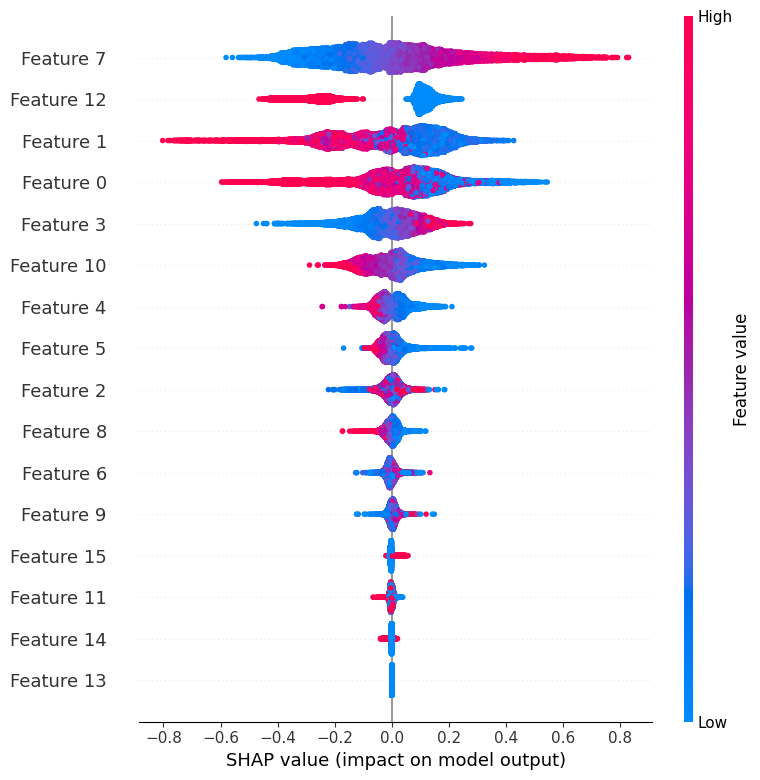

In [194]:
# create a summary plot
shap.summary_plot(shap_values,housing_prepared)

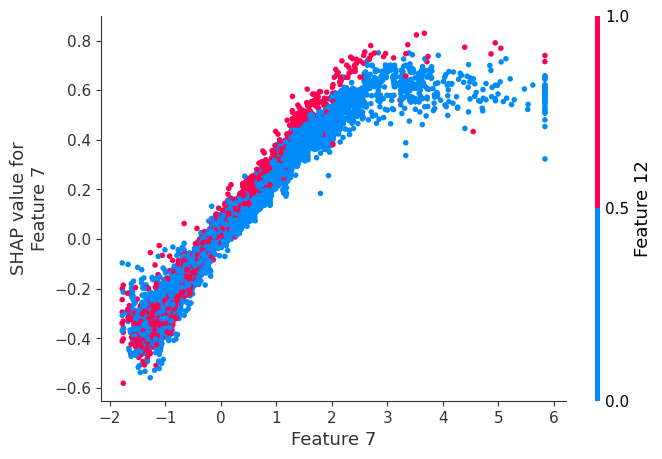

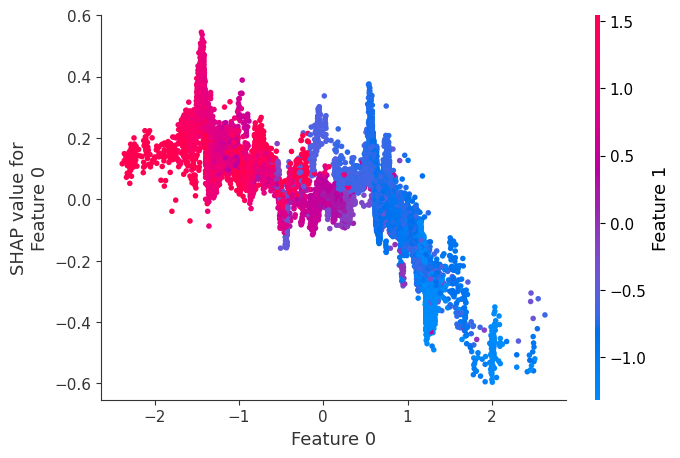

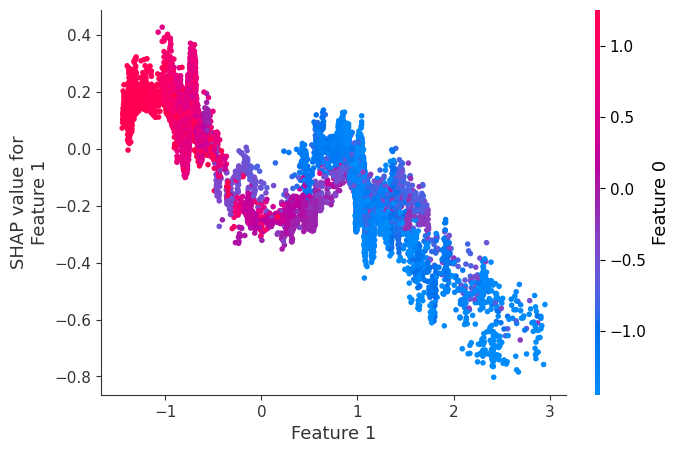

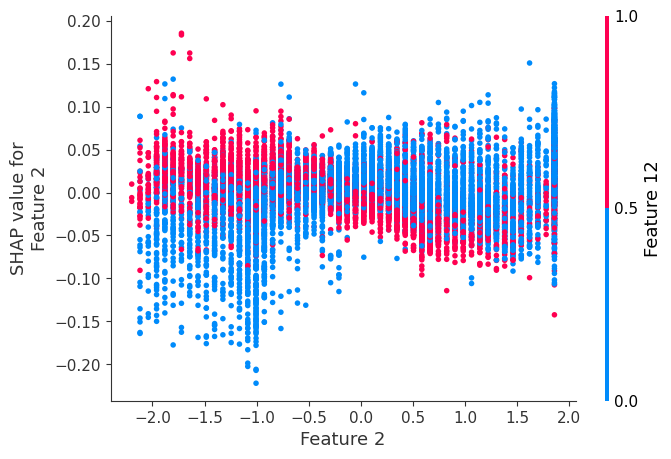

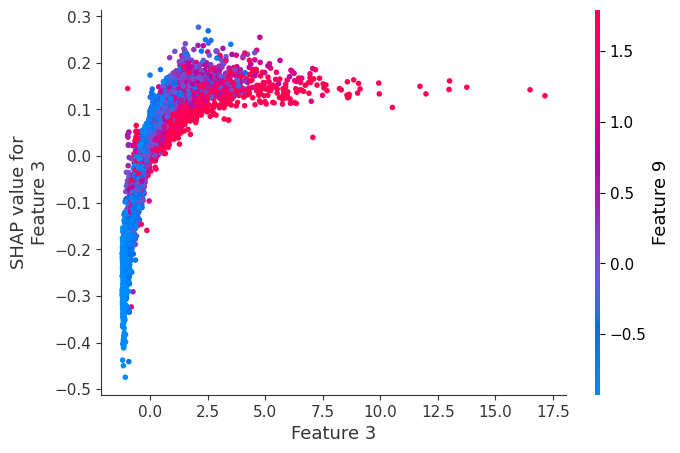

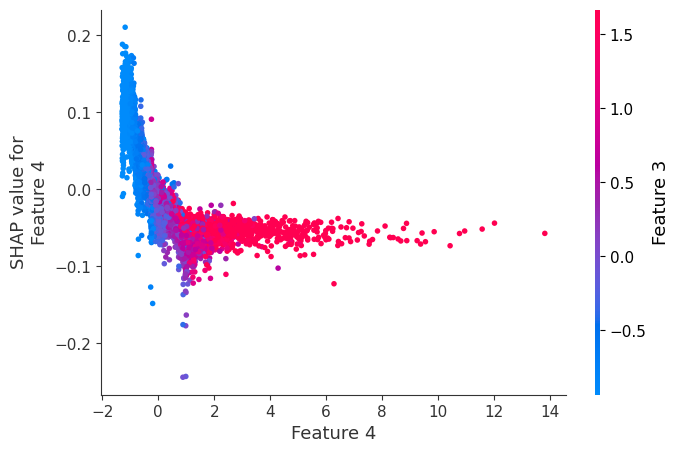

In [204]:
shap.dependence_plot(7, shap_values, housing_prepared)
housing_prepared_df = pd.DataFrame(
    housing_prepared,    # <- list of real names before transformation
)
# 3) Loop through top N features for individual plots
top_features = housing_prepared_df.columns[:5]   # top 5 by importance
for f in top_features:
    shap.dependence_plot(f, shap_values, housing_prepared)
    plt.show()